In [1]:
import np as np
import pandas as pd
from sklearn import set_config
import warnings
from sklearn.utils import resample

set_config(display='diagram')
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv("./../data/train.csv").dropna()
df_test_nolabel = pd.read_csv("./../data/test_nolabel.csv")
# df_sample_submission = pd.read_csv("./../data/sample_submission.csv").dropna()

In [3]:
df_train

,id,LoanNr_ChkDgt,Name,City,State,Bank,BankState,ApprovalDate,ApprovalFY,NoEmp,...,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,BalanceGross,Accept
0,2fa57387ae1,6213754009,SETANTA SETTERS,PITTSBURGH,PA,CITIZENS BANK NATL ASSOC,MA,1-Apr-03,2003,1,...,1,2,1,1,Y,N,30-Jun-03,"$5,440.00",$0.00,1
1,a66f9849d7f,1751224008,DURACLEAN BY SEITZER,MONTOURSVILLE,PA,MANUFACTURERS & TRADERS TR CO,NY,19-Dec-97,1998,20,...,0,0,25850,0,N,Y,28-Feb-98,"$33,800.00",$0.00,1
2,fb6a6d89487,6979444003,PC HAINES WALL & CEILING CONTR,SALUNGA,PA,CITIZENS BANK NATL ASSOC,RI,1-Dec-03,2004,9,...,0,9,1,2,Y,N,29-Feb-04,"$156,599.00",$0.00,1
3,0ac44b54067,5825754005,LESLIE A LANDIS,YORK,PA,MANUFACTURERS & TRADERS TR CO,MD,31-Oct-02,2003,3,...,2,5,1,1,0,N,31-Jan-03,"$40,000.00",$0.00,1
4,3a5ff625fa3,8989333001,"MAILBOXES, ETC.",PHILADELPHIA,PA,NEWTEK SMALL BUS. FINANCE INC.,NY,7-Feb-96,1996,3,...,0,0,50564,0,N,Y,31-Oct-96,"$100,000.00",$0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24614,ae972125b13,7387374007,HUNTINGDON CREAMERY,HUNTINGDON,PA,KISH BANK,PA,27-Apr-04,2004,2,...,2,0,1,1,0,N,31-May-04,"$20,000.00",$0.00,1
24615,95d6fb854b9,1175195009,MAJIK D.J. ENTERTAINMENT,FLEETWOOD,PA,CITIZENS BANK NATL ASSOC,RI,31-Jan-05,2005,2,...,0,2,1,1,N,N,30-Apr-06,"$10,000.00",$0.00,1
24616,5e446a47a0f,1797704005,MCCULLOUGH TOWING & STORAGE,PHILA,PA,SUSQUEHANNA BANK,PA,22-Jan-98,1998,3,...,0,0,1,0,N,Y,31-Mar-98,"$60,000.00",$0.00,1
24617,549dcfeb04e,3816914004,HALLS FLORIST,WILLIAMSPORT,PA,MANUFACTURERS & TRADERS TR CO,NY,29-Jun-00,2000,4,...,0,3,1,1,Y,N,31-Aug-04,"$10,000.00",$0.00,1


In [4]:
# Separate majority and minority classes
df_majority = df_train[df_train["Accept"] == 1]
df_minority = df_train[df_train["Accept"] == 0]

# Downsample majority class
df_majority_downsampled = resample(df_majority, replace=True, n_samples=(round(len(df_minority) * .9)), random_state=42)

# Combine minority class with downsampled majority class
df_train_resampled = np.concatenate((df_majority_downsampled, df_minority), axis=0)
df_train_resampled = pd.DataFrame(df_train_resampled, columns=df_train.columns)

df_train = df_train_resampled

In [5]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, \
    FunctionTransformer


def to_lowercase(df):
    """
    set all strings to lower case to be easier to group
    """
    df = df.apply(lambda col: col.str.lower())
    return df

def limit_outlier(df, max_value):
    """
    clamps the max and min value of a series, for prevent outliers
    from destroying statistic values
    """
    df = df.clip(0, max_value)
    return df

def fix_new_exists(df):
    """
    fixes newExists col to boolean values
    """
    df["NewExist"] = df["NewExist"].apply(lambda row: 0 if row in [0, 1] else 1)
    return df

def fix_franchise_code(df):
    """
    fixes FranchiseCode to {0, 1}
    """
    df["FranchiseCode"] = df["FranchiseCode"].apply(lambda row: 0 if row <= 1 else 1)
    return df

def fix_revlinecr(df):
    """
    fixes RevLineCr to {0, 1}
    """
    df["RevLineCr"] = df["RevLineCr"].apply(lambda row: 0 if row in ["N", 0] else 1)
    return df

def fix_lowdoc(df):
    """
    fixes LowDoc to {0, 1}
    """
    df["LowDoc"] = df["LowDoc"].apply(lambda row: 1 if row in ["Y", "S"] else 0)
    return df


def fix_disbursment_gross(df):
    """
    fixes disbursment extracting real value from string
    """
    df["DisbursementGross"] = df["DisbursementGross"]\
        .str.extract("(\d+(?:,\d+)*(?:\.\d+)?)")[0]\
        .str.replace(",", "")\
        .astype("float")
    return df

def fix_urban_rural(df):
    """
    fixes UrbanRural to {0, 1}
    """
    df["UrbanRural"] = df["UrbanRural"].apply(lambda row: 1 if row in ["Y", "S"] else 0)
    return df

def get_approval_year(df):
    """
    extracts year from date ApprovalDate
    """
    df['ApprovalDate'] = df['ApprovalDate'].astype('datetime64[ns]').dt.year
    return df

def identity(df):
    return df


preprocessor = ColumnTransformer(
    transformers=[
        # group 1 -> Set to lower and onehot with in freq 3
        # ("group_a", Pipeline([
        #     ("a1", FunctionTransformer(to_lowercase)),
        #     ("a2", OneHotEncoder(handle_unknown='ignore', sparse=True))
        # ]), ["Name"]),

        # group 2 -> Set to lower and onehot with in freq 300
        ("group_b", Pipeline([
            ("b1", FunctionTransformer(to_lowercase)),
            ("b2", OneHotEncoder(handle_unknown='ignore', sparse=False))
        # ]), ["City", "Bank", "BankState"]),
        ]), ["BankState"]),

        # group 3 -> clamps values [0, 155] and scales in standard dist
        # si se quiere cambiar por otras opciones crear una función como la de abajo...
        ("group_c", Pipeline([
            ("c1", FunctionTransformer(limit_outlier, kw_args={'max_value': 155})),
            ("c2", StandardScaler()),
        ]), ["NoEmp"]),

        # # group 4 -> sustituye {0, 1, 2} por {1, 2}
        ("group_d", Pipeline([
            ("d1", FunctionTransformer(fix_new_exists)),
            ("d2", SimpleImputer(strategy="most_frequent")),
        ]), ["NewExist"]),

        # group 5 -> clamps values [0, 1027] and scales in standard dist
        # si se quiere cambiar por otras opciones crear una función como la de abajo...
        ("group_e", Pipeline([
            ("e1", FunctionTransformer(limit_outlier, kw_args={'max_value': 1027})),
            ("e2", StandardScaler()),
        ]), ["CreateJob", "RetainedJob"]),

        # group 6 -> transforma la columna a bool
        ("group_f", Pipeline([
            # ("f1", FunctionTransformer(fix_franchise_code)),
            ("f1", FunctionTransformer(identity)),
        ]), ["FranchiseCode"]),

        # group 7 -> transforma la columna a bool
        ("group_g", Pipeline([
            ("g1", FunctionTransformer(fix_revlinecr)),
        ]), ["RevLineCr"]),
        #
        # group 8 -> transforma la columna a bool
        ("group_h", Pipeline([
            ("h1", FunctionTransformer(fix_lowdoc)),
        ]), ["LowDoc"]),

        # # group 9 -> extrae el valor con un regex y lo escala
        ("group_i", Pipeline([
            ("i1", FunctionTransformer(fix_disbursment_gross)),
            ("d2", SimpleImputer(strategy="mean")),
            ("i2", StandardScaler()),
        ]), ["DisbursementGross"]),
        #
        # group 10 -> transforma la columna a bool
        ("group_j", Pipeline([
            ("fj", FunctionTransformer(fix_urban_rural)),
        ]), ["UrbanRural"]),

        # group 11 -> approval year
        ("group_k", Pipeline([
            ("k1", FunctionTransformer(get_approval_year)),
            ("i2", StandardScaler()),
        ]), ["ApprovalDate", "ApprovalFY"]),
    ],
    remainder='drop'
)

# preprocessor_label = LabelEncoder()
preprocessor.fit(df_train)
# preprocessor_label.fit(df_train["Accept"])

ColumnTransformer(transformers=[('group_b',
                                 Pipeline(steps=[('b1',
                                                  FunctionTransformer(func=<function to_lowercase at 0x135623ee0>)),
                                                 ('b2',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['BankState']),
                                ('group_c',
                                 Pipeline(steps=[('c1',
                                                  FunctionTransformer(func=<function limit_outlier at 0x1440dd940>,
                                                                      kw_args={'max_value': 155})),
                                                 ('c2', StandardScaler())...
                                                  FunctionTransformer(func=<function fix_disbursment_gross at 0x14413d550>)),
                                                 ('d2', SimpleImputer()),
                                                 ('i2', StandardScaler())]),
                                 ['DisbursementGross']),
                                ('group_j',
                                 Pipeline(steps=[('fj',
                                                  FunctionTransformer(func=<function fix_urban_rural at 0x14413d5e0>))]),
                                 ['UrbanRural']),
                                ('group_k',
                                 Pipeline(steps=[('k1',
                                                  FunctionTransformer(func=<function get_approval_year at 0x14413d670>)),
                                                 ('i2', StandardScaler())]),
                                 ['ApprovalDate', 'ApprovalFY'])])

In [6]:
X_train = preprocessor.transform(df_train)
y_train = df_train["Accept"].values.astype("int")

In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn import metrics


x = df_train.drop('Accept', axis=1)
y = df_train['Accept'].values.astype('int')
x_train, x_test, y_train, y_test = train_test_split(df_train, y, test_size=0.25, random_state=33)


estimators = [
    ("rf", RandomForestClassifier()),
    ("gb", GradientBoostingClassifier()),
    ("svc", SVC())
]
stacking_clf = StackingClassifier(
    estimators=estimators
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("stacking", stacking_clf)
])

param_grid = {
    "stacking__rf__n_estimators": [180, 200, 220, 240],
    "stacking__rf__max_depth": [10, 15, 20],
    "stacking__rf__min_samples_leaf": [10, 20, 30, 40],
    "stacking__rf__max_features": ['sqrt', 'log2'],
    "stacking__gb__learning_rate": [0.05, 0.1, 0.15],
    "stacking__gb__min_samples_split": [2, 4, 6],
    "stacking__gb__n_estimators": [180],
    "stacking__gb__min_samples_leaf": [50],
    "stacking__gb__max_depth": [15],
    "stacking__gb__max_features": ['sqrt'],
    "stacking__gb__subsample": [0.8],
    "stacking__svc__C": [1],
}

search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
search.fit(x_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)


y_test_pred = search.predict(x_test)
print("Accuracy in training ", metrics.accuracy_score(y_test, y_test_pred))
print("f-score in training ", metrics.f1_score(y_test, y_test_pred))

pipeline

/Users/apabook/Desktop/muirst/cdaw/sitc/venv/lib/python3.8/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/Users/apabook/Desktop/muirst/cdaw/sitc/venv/lib/python3.8/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Se

Best parameter (CV score=0.704):
{'stacking__gb__learning_rate': 0.1, 'stacking__gb__max_depth': 15, 'stacking__gb__max_features': 'sqrt', 'stacking__gb__min_samples_leaf': 50, 'stacking__gb__min_samples_split': 6, 'stacking__gb__n_estimators': 180, 'stacking__gb__subsample': 0.8, 'stacking__rf__max_depth': 20, 'stacking__rf__max_features': 'log2', 'stacking__rf__min_samples_leaf': 10, 'stacking__rf__n_estimators': 200, 'stacking__svc__C': 1}
Accuracy in training  0.6997767857142857
f-score in training  0.6846424384525206


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('group_b',
                                                  Pipeline(steps=[('b1',
                                                                   FunctionTransformer(func=<function to_lowercase at 0x135623ee0>)),
                                                                  ('b2',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['BankState']),
                                                 ('group_c',
                                                  Pipeline(steps=[('c1',
                                                                   FunctionTransformer(func=<function limit_outlier at 0x1440dd940>,
                                                                                       kw_args={'max_value...
                                                                   FunctionTransformer(func=<function fix_urban_rural at 0x14413d5e0>))]),
                                                  ['UrbanRural']),
                                                 ('group_k',
                                                  Pipeline(steps=[('k1',
                                                                   FunctionTransformer(func=<function get_approval_year at 0x14413d670>)),
                                                                  ('i2',
                                                                   StandardScaler())]),
                                                  ['ApprovalDate',
                                                   'ApprovalFY'])])),
                ('stacking',
                 StackingClassifier(estimators=[('rf',
                                                 RandomForestClassifier()),
                                                ('gb',
                                                 GradientBoostingClassifier()),
                                                ('svc', SVC())]))])

In [8]:
from sklearn.metrics import RocCurveDisplay, confusion_matrix, classification_report
print(confusion_matrix(y_test, y_test_pred))

[[670 255]
 [283 584]]


In [9]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.70      0.72      0.71       925
           1       0.70      0.67      0.68       867

    accuracy                           0.70      1792
   macro avg       0.70      0.70      0.70      1792
weighted avg       0.70      0.70      0.70      1792



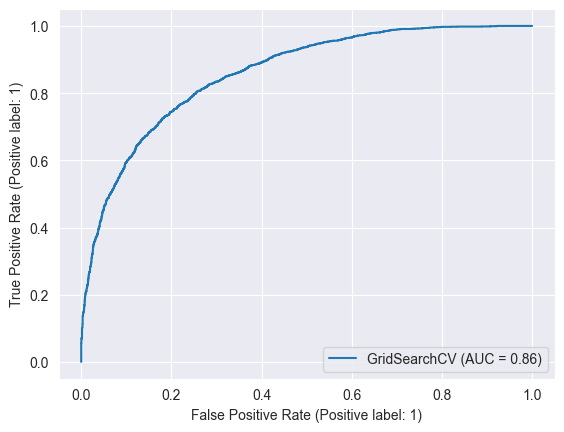

In [10]:
RocCurveDisplay.from_estimator(search, x_train, y_train)

In [11]:
from datetime import datetime

now = datetime.now()
date_string = now.strftime("%Y%m%d_%H%M")

sample_out = pd.DataFrame()
sample_out["id"] = df_test_nolabel["id"]
sample_out["Accept"] = search.predict(df_test_nolabel)

sample_out.to_csv(f"./../data/submission_{date_string}_Stacking.csv", index=False)
sample_out.groupby("Accept").size()

Accept
0    1779
1    1495
dtype: int64